# Géométrie et espaces de formes - TP 2

## 0. Appariement linéaire (méthode du TP 1)

On reprend la situation de la section 2 du premier TP : on définit une transformation $\phi=\text{Id}+v$ sur $\R^2$ vérifiant des contraintes ponctuelles $\phi(y_i)=z_i$, et telle que $\|v\|_V$ est minimale, où $V$ est un espace de Hilbert de champs de vecteurs de noyau $K_V$. Voici des fonctions reprenant ce qui a été fait dans cette partie : 

Note du tableau : 
1) Solve the injectivity problem by doing compositions of "small" deformations.

$\phi^1$ s.t $\phi^1(y_i) = q_i^1$ 

$\phi^2$ s.t $\phi^2(q_i^1) = q_i^2$

$\phi^3$ s.t $\phi^3(q_i^2) = z_i$

and introduce $\phi = \phi^3 \circ \phi^2 \circ \phi^1$

On what conditions on $v$ does $\phi = Id + v$ is injective i.e $\phi(x)\neq \phi(y) \Longrightarrow x - y \neq 0$.

$\phi(x) - \phi(y) = x - y + v(x) - v(y) \Longrightarrow ||\phi(x) - \phi(y)|| \geq ||x - y|| - ||v(x) - v(y)|| \geq ||x - y||(1 - \alpha)$ if $v$ is $\alpha$-Lipschitz, with $\alpha < 1$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Fonctions reprenant les méthodes vues au TP1

def KernelMatrix(x,y,h):
    # calcul de la matrice noyau K(x,y) de taille (m,n)
    # de coefficients K(x_i,y_j) = h(||x_i-y_j||^2) 
    # ou h est une fonction scalaire,
    # les x_i sont m points dans R^d, et les y_j n points dans R^d,
    # donnes sous forme de tableaux x, y de tailles (m,d) et (n,d) 
    return h(np.sum((x[:,None,:]-y[None,:,:])**2,axis=2))

def gauss(sigma) :
    # noyau de Gauss h(r2)=exp(-r2/sigma^2)
    # N.B. l'argument r2 est censé correspondre au carré de la norme euclidienne
    # entre les points (e.g. r2 = ||x-y||^2)
    # Ceci permet d'éviter un calcul de racine carrée inutile et non différentiable en 0.
    def f(r2) :
        return np.exp(-r2/sigma**2)
    return f

def cauchy(sigma) :
    # noyau de Cauchy h(r2)=1/(1+r2/sigma^2)
    def f(r2) :
        return 1/(1+r2/sigma**2)
    return f




def MatchingLinear(y,z,h,l=0):
    # Appariement lineaire de points labellisés dans R^d
    # y et z sont des tableaux de taille (n,d) donnant les coordonnees
    # de n points y_i (points sources) 
    # et leurs correspondants z_i (points cibles)
    # h est la fonction scalaire definissant le noyau,
    # l est le parametre de relaxation,
    # retourne la transformation phi:R^d->R^d realisant l'appariement
    a = np.linalg.solve(KernelMatrix(y,y,h)+l*np.eye(y.shape[0]),z-y)
    def phi(x):
        return x+np.dot(KernelMatrix(x,y,h),a)
    return phi

def MatchingTPS(y,z,l=0):
    # Fonction similaire a MatchingLinear mais la methode utilisee ici 
    # est la methode Thin Plate Splines (cf TP1, questions 13 et 14)
    # remarque : la fonction noyau h(r)=r^2log(r) n'est valable en theorie
    # que pour des donnees en dimension 2.
    def TPSfun(r2):
        # fonction h(r2) = r2 log(sqrt(r2))
        r2[r2==0]=1
        return r2 * np.log(np.sqrt(r2))
    h = TPSfun
    n,d = y.shape
    Kyy =  KernelMatrix(y,y,h) + l*np.eye(n)
    yt = np.concatenate((np.ones((n,1)),y),axis=1)
    M1 = np.concatenate((Kyy,yt),axis=1)
    M2 = np.concatenate((yt.T,np.zeros((d+1,d+1))),axis=1)
    M = np.concatenate((M1,M2))  
    c = z-y
    ct = np.concatenate((c,np.zeros((d+1,c.shape[1]))))
    a = np.linalg.solve(M,ct)
    def phi(x):
        Kxy = KernelMatrix(x,y,h)
        nx = x.shape[0]
        xt = np.concatenate((np.ones((nx,1)),x),axis=1)
        N = np.concatenate((Kxy,xt),axis=1)
        return x+np.dot(N,a)
    return phi





# Fonctions d'affichage

def PlotConfig(lmk, pts=None, clr='k', phi=lambda x:x, withgrid=True, title=None):
    # Fonction pour l'affichage d'une configuration de points, avec ou sans déformation.
    # arguments :
    #    lmk : tableau de taille (n,2), coordonnées des points de référence (y_i ou z_i)
    #    pts : optionnel, tableau (N,2), coordonnées de points additionnels.
    #    clr : optionnel, caractère (ex 'r' ou 'b') spécifiant la couleur utilisée pour afficher les points.
    #    phi : optionnel, fonction Python renvoyée par MatchingLinear ou une méthode similaire,
    #          donnant la transformation phi. Si phi est donné, la transformation phi est appliquée 
    #          sur les points lmk et pts.
    #    withgrid : optionnel, si False, on n'affiche pas la grille de déformation.
    #    title : optionnel, titre de la figure
    if type(pts)==type(None):
        pts = lmk
    plt.axis('equal')
    if withgrid:
        # définition d'une grille carrée adaptée aux points
        mn, mx = lmk.min(axis=0), lmk.max(axis=0)
        c, sz = (mn+mx)/2, 1.2*(mx-mn).max()
        a, b = c-sz/2, c+sz/2
        ng = 200
        X1, X2 = np.meshgrid(np.linspace(a[0],b[0],ng),np.linspace(a[1],b[1],ng))
        x = np.concatenate((X1.reshape(ng*ng,1),X2.reshape(ng*ng,1)),axis=1)
        x = phi(x)
        X1 = x[:,0].reshape(ng,ng)
        X2 = x[:,1].reshape(ng,ng)
        plt.plot(X1,X2,clr,linewidth=.25)
        plt.plot(X1.T,X2.T,clr,linewidth=.25)
    phipts = phi(pts)
    philmk = phi(lmk)
    plt.plot(phipts[:,0],phipts[:,1],'.'+clr,markersize=.1)
    plt.plot(philmk[:,0],philmk[:,1],'o'+clr)
    if title:
        plt.title(title)

def PlotResMatching(phi, lmk1, lmk2, pts1=None, Q=None, withgrid=True, title=None):
    # Fonction pour l'affichage du résultat d'un appariement de points. 
    # arguments :
    #    phi : fonction Python renvoyée par MatchingLinear ou une méthode similaire, donnant la transformation phi
    #    lmk1 : tableau de taille (n,2), coordonnées des points sources (y_i)
    #    lmk2 : tableau de taille (n,2), coordonnées des points cibles (z_i)
    #    pts1 : optionnel, tableau (N,2), coordonnées de points additionnels représentant la forme/image source
    #    Q : optionnel, tableau de taille (n,2,nt) donnant les trajectoires des points de référence (pour la partie 1)
    #    withgrid : optionnel, si False, on n'affiche pas la grille de déformation
    #    title : optionnel, titre de la figure
    PlotConfig(lmk1, withgrid=False, clr='b')
    PlotConfig(lmk2, withgrid=False, clr='r')
    PlotConfig(lmk1, pts=pts1, phi=phi, clr='k', withgrid=withgrid)
    if Q is None:
        Q = np.concatenate((lmk1[:,:,None], lmk2[:,:,None]), axis=2)
    plt.plot(Q[:,0,:].T,Q[:,1,:].T, 'k');
    plt.plot(Q[:,0,1:-1].T,Q[:,1,1:-1].T, 'k+');
    if title:
        plt.title(title)

    
    
# divers

def load(fname='store.pckl'):
    # chargement d'un fichier pickle
    import pickle
    f = open(fname, 'rb')
    obj = pickle.load(f)
    f.close()
    return obj

<br>

Voici quelques résultats utilisant ces fonctions. D'abord une configuration aléatoire :

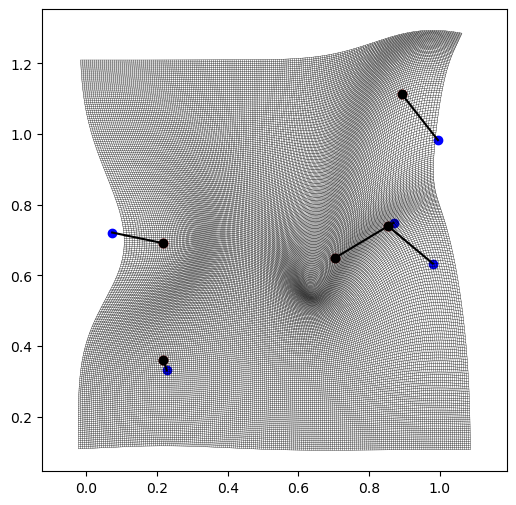

In [3]:
# Exemple d'appariement lineaire avec points aleatoires
lmk1 = np.random.rand(5,2)
lmk2 = lmk1 + .1 * np.random.randn(5,2)
sigma = .25
phi = MatchingLinear(lmk1,lmk2,gauss(sigma))
plt.rcParams['figure.figsize'] = [6, 6]
PlotResMatching(phi,lmk1,lmk2)

<br>

Ensuite des points repérées sur des images de poissons :

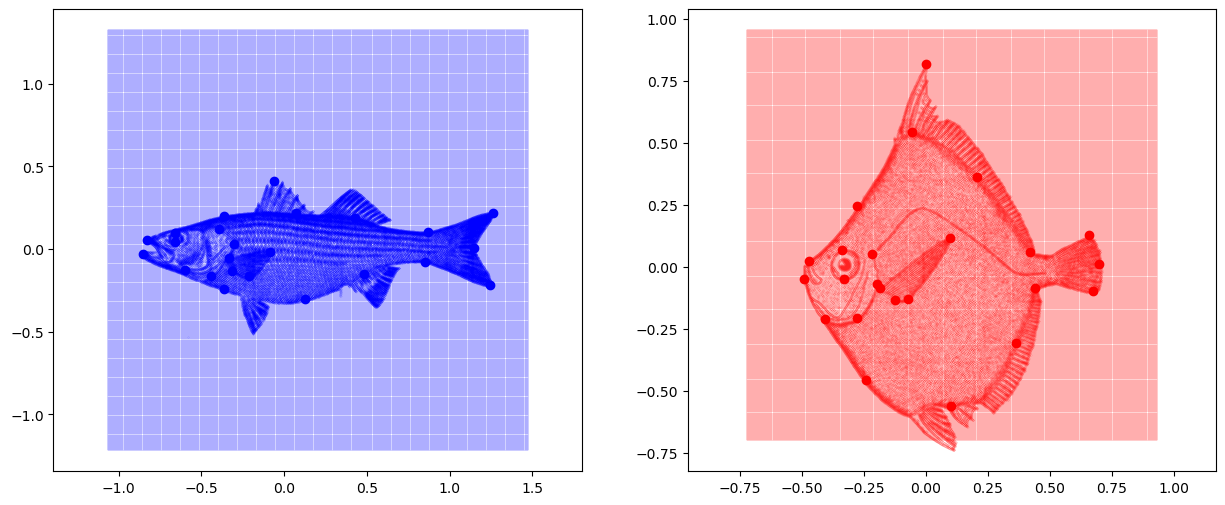

In [4]:
# Chargement et affichage des donnees "poissons"
pts1,pts2,lmk1,lmk2 = load('fish.pckl')
plt.rcParams['figure.figsize'] = [15, 6]
plt.figure()
plt.subplot(1,2,1)
PlotConfig(lmk1, pts1, clr='b')
plt.subplot(1,2,2)
PlotConfig(lmk2,pts2, clr='r')

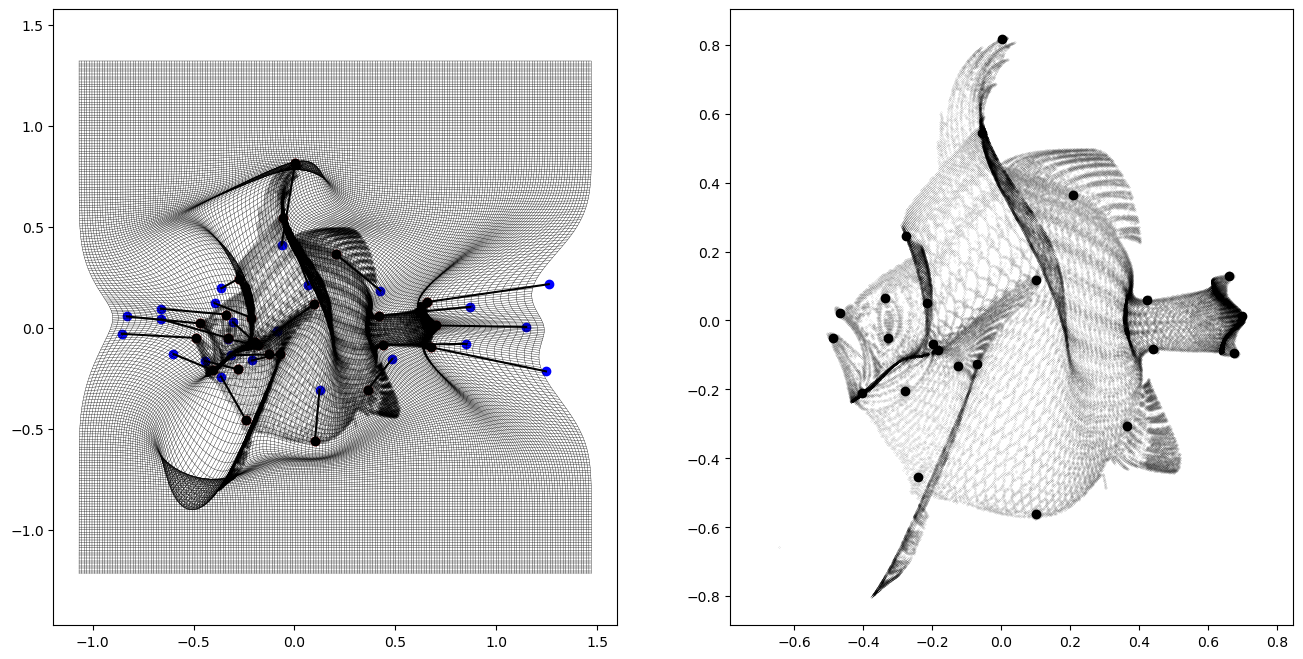

In [5]:
# Appariement lineaire avec les donnees "poissons"
sigma = .25
phi = MatchingLinear(lmk1,lmk2,gauss(sigma))
plt.rcParams['figure.figsize'] = [16, 8]
plt.subplot(1,2,1)
PlotResMatching(phi, lmk1, lmk2, pts1=pts1)
plt.subplot(1,2,2)
PlotConfig(lmk1,pts1,phi=phi, withgrid=False)

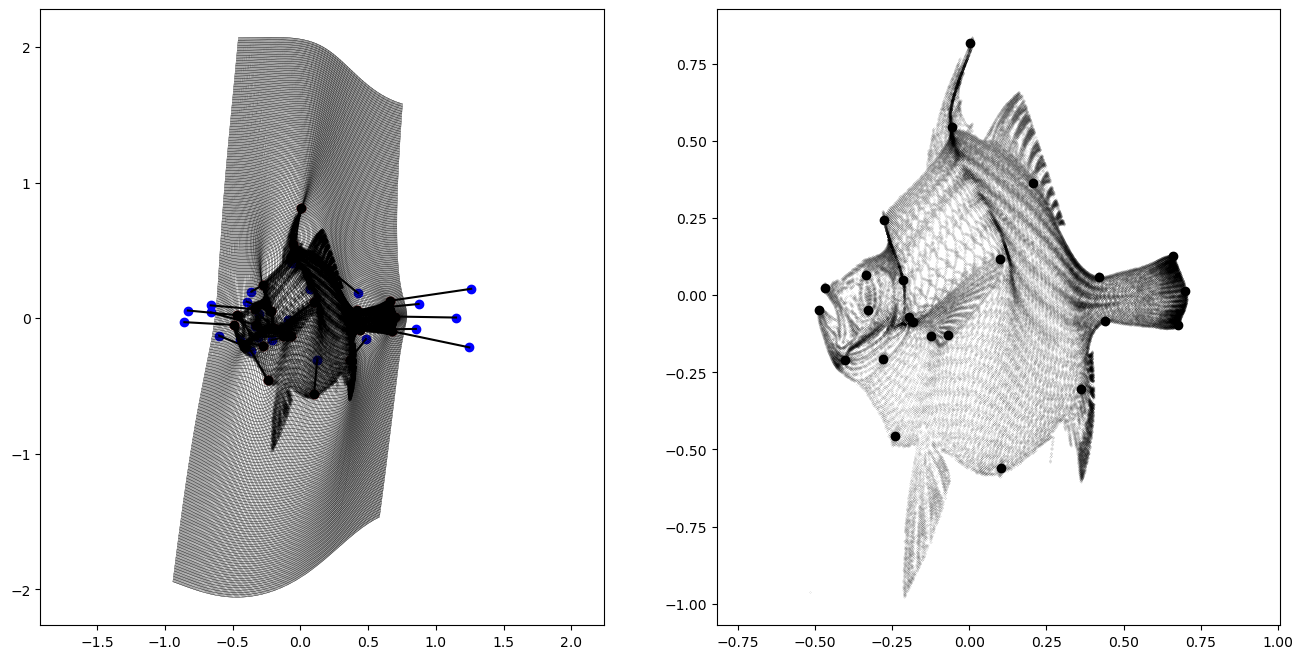

In [6]:
# Appariement par la méthode Thin Plate Splines
sigma = .25
phi = MatchingTPS(lmk1,lmk2)
plt.rcParams['figure.figsize'] = [16, 8]
plt.subplot(1,2,1)
PlotResMatching(phi, lmk1, lmk2, pts1=pts1)
plt.subplot(1,2,2)
PlotConfig(lmk1,pts1,phi=phi, withgrid=False)

$\newcommand{\id}{{\mathrm{id}}\,}$

## 1. De l’appariement linéaire aux difféomorphismes

Nous allons voir comment
la composition de petites déformations permet de résoudre le problème de non-inversibilité de l'approche linéaire.
Pour cela on reprend la situation de la section 2 du premier TP, mais au lieu de réaliser l'appariement des $y_i$ vers les $z_i$ en une seule étape, on introduit des points intermédiaires 
$y_i=q_i^1,q_i^2,\cdots,q_i^{n_t}=z_i$ régulièrement espacés le long du segment $[y_i,z_i]$ et on calcule l'appariement linéaire des $q_i^t$ vers les $q_i^{t+1}$, successivement pour $1\leq t\leq n_t-1$. On compose ensuite simplement les déformations $\phi^t=\id+v^t$ obtenues : $\phi:=\phi^{n_t-1}\circ\cdots\circ\phi^1$. 

Voici une fonction pour calculer les points intermédiaires le long des segments $[y_i,z_i]$:

In [7]:
def LinTraj(y,z,nt=10):
    # renvoie Q tableau de taille (n,d,nt) donnant les coordonnees de points
    # q_i^t de R^d regulierement espaces le long des segments [y_i,z_i]
    # arguments:
    #    y :  tableau (n,d), coordonnées des points y_i
    #    z :  tableau (n,d), coordonnées des points z_i
    #    nt :  nombre de points le long du segment (incluant les extrémités)
    Q = np.dot(y[:,:,None],np.linspace(1,0,nt)[None,:]) + np.dot(z[:,:,None],np.linspace(0,1,nt)[None,:])
    return Q

<br>

__Question 1__ : Tester l'approche proposée sur un exemple où l'appariement linéaire aboutit à une déformation $\phi$ non-inversible (grille de déformation "repliée"). Utiliser la fonction `LinTraj` pour construire les points intermédiaires $q_i^t$ puis écrire une fonction
`MatchingSteps(Q,h)` sur le modèle de `MatchingLinear(y,z,h)`
qui calcule les $\phi(x_j)$ pour des points quelconques $x_j$ donnés en entrée.
Afficher les positions des points et les grilles de déformations obtenues. On testera plusieurs valeurs pour $n_t$ : $n_t=3, 5, 10$ par exemple.

In [8]:
def MatchingSteps(Q,h):
    # appariement de points labellises par composition d'appariement lineaires
    # Q est un tableau de taille (n,d,nt) donnant les coordonnees des points
    # q_i^t de R^d, pour 1 <= i <= n et 1 <= t <= nt
    #
    #
    list_phi = []
    nt = Q.shape[2]
    for i in range(nt - 1):
        list_phi.append(MatchingLinear(Q[:,:,i], Q[:,:,i+1],h))
    def phi(x):
        for i in range(nt - 1):
            x = list_phi[i](x)
        return x
    return phi

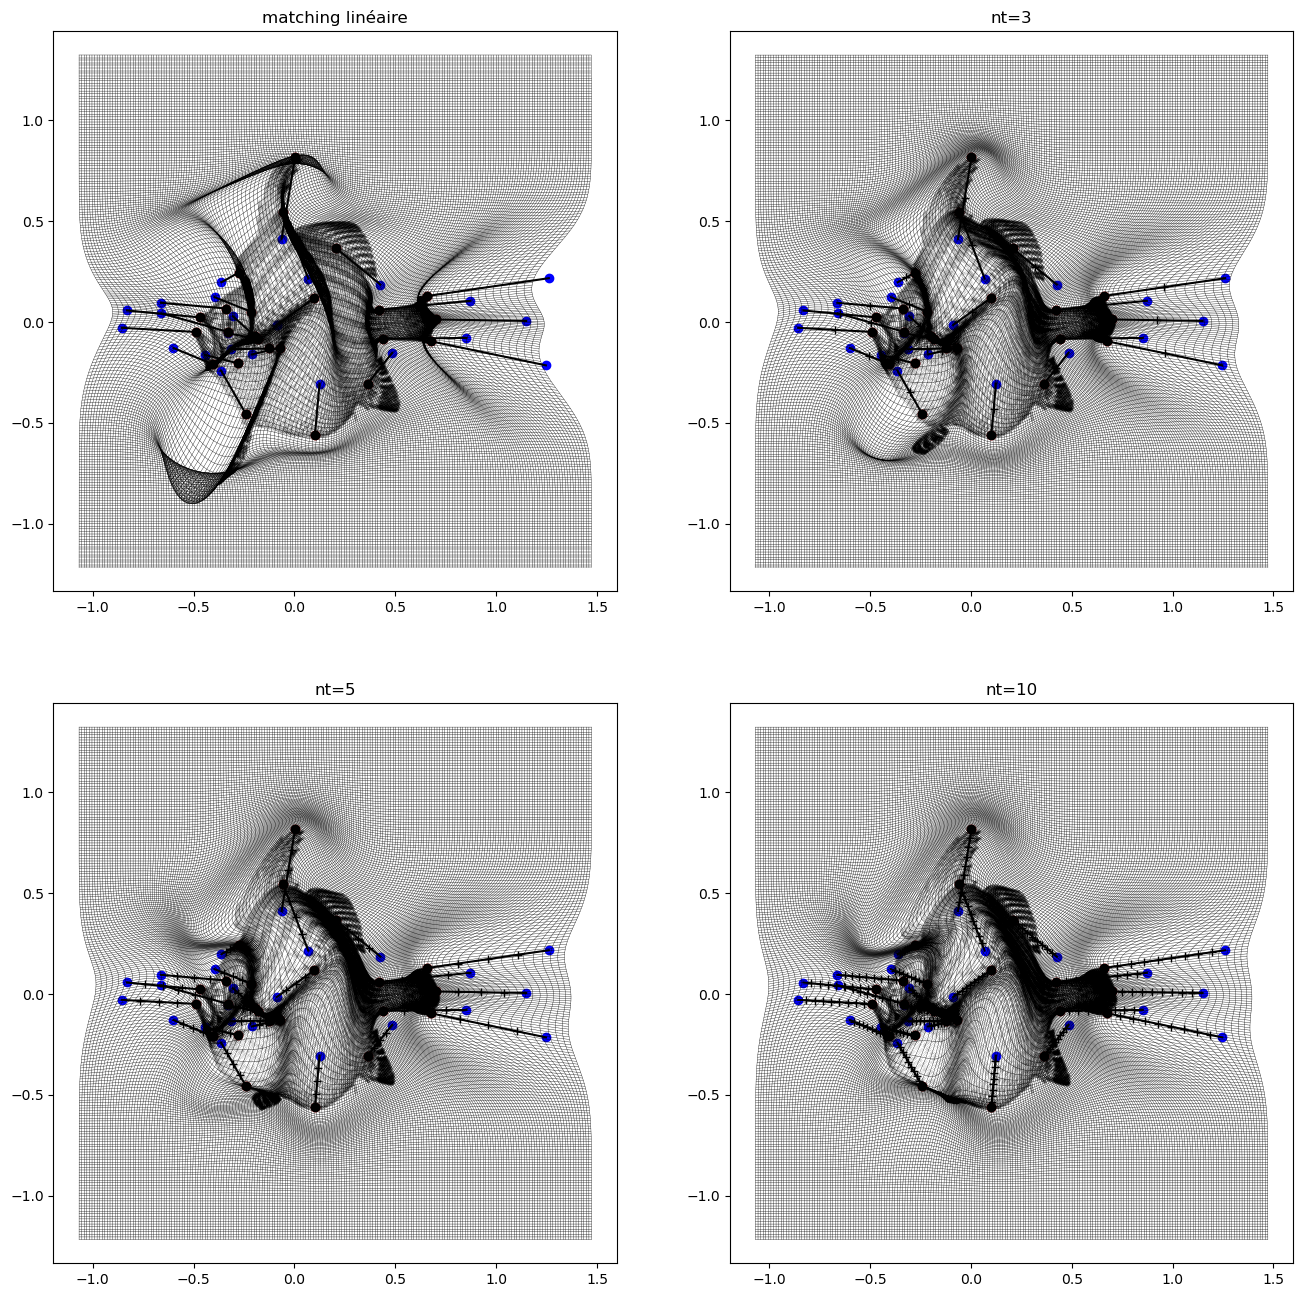

In [9]:
# test avec les données "poisson"
pts1,pts2,lmk1,lmk2 = load('fish.pckl')

sigma = .25
phi = MatchingLinear(lmk1,lmk2,gauss(sigma))

plt.rcParams['figure.figsize'] = [16, 16]
plt.subplot(2,2,1)
PlotResMatching(phi, lmk1, lmk2, pts1, title="matching linéaire")

Q = LinTraj(lmk1, lmk2, nt=3)
phi = MatchingSteps(Q,gauss(sigma))
plt.subplot(2,2,2)
PlotResMatching(phi, lmk1, lmk2, pts1, Q, title="nt=3")

Q = LinTraj(lmk1, lmk2, nt=5)
phi = MatchingSteps(Q,gauss(sigma))
plt.subplot(2,2,3)
PlotResMatching(phi, lmk1, lmk2, pts1, Q, title="nt=5")

Q = LinTraj(lmk1, lmk2, nt=10)
phi = MatchingSteps(Q,gauss(sigma))
plt.subplot(2,2,4)
PlotResMatching(phi, lmk1, lmk2, pts1, Q, title = "nt=10")

$\def\scal#1#2{\left\langle #1\mathbin{,}#2\right\rangle}$

Les positions des points intermédiaires $q_i^t$, $2\leq t\leq n_t-1$ sont en fait libres et on peut chercher à optimiser ces positions en minimisant l'énergie suivante
$$ J(q^2,\ldots,q^{n_t-1}):=\sum_{t=1}^{n_t-1}\scal{q^{t+1}-q^t}{K(q^t)^{-1}(q^{t+1}-q^t)}.$$

Pour éviter le calcul fastidieux du gradient de cette fonctionnelle, nous allons utiliser le module d'autodifférentiation de PyTorch. Voici tout d'abord un mini tutoriel d'introduction. 

In [10]:
# Mini tutoriel d'utilisation de PyTorch et de son module d'autodifferentiation

import torch
from torch.autograd import grad

# definition d'une variable x, vecteur de taille 2 arbitraire, par rapport auquel 
# on pourra calculer des gradients:
x = torch.tensor([1.5,2.4], requires_grad=True)

# On peut aussi partir d'un vecteur numpy et le convertir en variable pytorch :
x_np = np.array([1.5,2.4])
x = torch.tensor(x_np, requires_grad=True)
 
# expression de x dont on doit calculer le gradient :
fx = torch.sum(torch.cos((x**2-2)**2))

# calcul automatique du gradient de f(x) par rapport a x :
# remarque : le [0] a la fin est necessaire car la sortie de grad est un tuple
gfx = grad(fx,x)[0]
print("gradient auto =",gfx)

# on compare avec la formule derivee a la main :
gfx_bis = 2*(x*x-2)*(2*x)*(-torch.sin((x**2-2)**2))
print("gradient mano =",gfx_bis)

# Pour des calculs impliquant des dérivées secondes, il faut spécifier l'option create_graph=True :
fx = torch.sum(torch.cos((x**2-2)**2))

gfx = grad(fx,x,create_graph=True)[0]
g2fx = grad(torch.norm(gfx),x)[0]
print("dérivée seconde =",g2fx)

gradient auto = tensor([ -0.0937, -36.0960], dtype=torch.float64)
gradient mano = tensor([ -0.0937, -36.0960], dtype=torch.float64, grad_fn=<MulBackward0>)
dérivée seconde = tensor([8.9088e-03, 6.0556e+01], dtype=torch.float64)


Pour plus de détails on pourra consulter ce notebook : 
https://nbviewer.org/urls/plmlab.math.cnrs.fr/glaunes/tp_enseignement/raw/master/M2_Percep/Tuto_Autodiff_PyTorch.ipynb

ainsi que toutes les ressources disponibles sur le site de la librairie : https://pytorch.org

<br>

__Question 2__ : Ecrire une fonction `Energy(Q,h)`
qui renvoie la valeur de la fonctionnelle. L'entrée $Q$ est supposée être de type `torch.tensor`, et la fonction $h$ ainsi que la fonction `KernelMatrix` doivent être réécrites avec la syntaxe de PyTorch, de telle manière que la fonction puisse être différentiée.  

On a $Q = [q^1, \cdots, q^{n_t}]$

In [11]:
import torch

def gauss_torch(sigma) :
    # version PyTorch de la fonction gauss
    # N.B. on enlève le carré de la formule
    # afin que la fonction passée soit une fonction du carré 
    # de la norme ; ceci pour garder des fonctions différentiables
    def f(r2) :
        return torch.exp(-r2/sigma**2)
    return f

def KernelMatrix_torch(x,y,h):
    # réécriture de KernelMatrix pour utiliser PyTorch à la place de NumPy
    return h(torch.sum((x[:,None,:]-y[None,:,:])**2,axis=2)) #sum for the squared euclidian distance

def Energy(Q,h):
    # renvoie la valeur de J pour une trajectoire quelconque
    # Q tenseur de taille (n,d,nt) de type torch.tensor
    # h est une fonction scalaire
    nt = Q.shape[2]
    res = 0
    for i in range(nt - 1):
        gamma = Q[:,:,i+1] - Q[:,:,i] 
        Kern = KernelMatrix_torch(Q[:,:,i],Q[:,:,i], h)
        inter = torch.linalg.solve(Kern,gamma)
        res += torch.sum(gamma*inter)
    return res

$ $
$ $

__Question 3__ : Pour $n_t=5$, écrire une descente de gradient à pas fixe sur la fonctionnelle précédente. Tester d'abord pour des configurations de 5 points tirés aléatoirement (faire $2000$ itérations, pas de descente $\eta=0.01$), puis pour l'exemple des poissons (prendre $\eta=0.00001$).

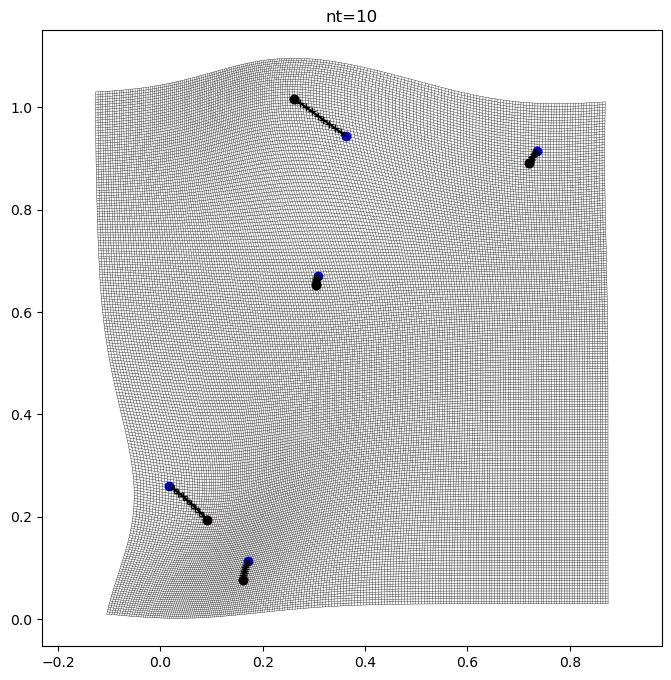

In [12]:
lmk1 = np.random.rand(5,2)
lmk2 = lmk1 + .1*np.random.randn(5,2)
sigma = .25
h = gauss_torch(sigma)
Q = LinTraj(lmk1,lmk2,nt=10)
Q = torch.tensor(Q, requires_grad = True) # conversion to tensor
nt = Q.shape[2]
eta = 0.01
for k in range(2000):
    J = Energy(Q,h)
    G = grad(J,Q)[0]
    Q[:,:,1:nt-1].data -= eta*G[:,:,1:nt-1].data #first and last points are fixed
Q = Q.detach().numpy() #convert tensor to numpy
phi = MatchingSteps(Q,gauss(sigma))
plt.figure(figsize = (8,8))
PlotResMatching(phi,lmk1,lmk2,Q=Q,title = 'nt=10')

<!-- $\newenvironment{acc}
{\left\{\begin{array}{l}}
{\end{array}\right.}
\newcommand{\bacc}{\begin{acc}}
\newcommand{\eacc}{\end{acc}}$ -->

__Question 4__ : Expliquer pourquoi le modèle précédent
constitue en fait une première implémentation de l'approche difféomorphique qui définit les déformations $\phi$ par intégration d'une famille de champs de vecteurs
$(v(t,\cdot))_{t\in[0,1]}$ dans $V$:
$$
\begin{cases}
\phi:=\phi(1,\cdot),\\
\frac{\partial\phi}{\partial t}(t,x)=v(t,\phi(t,x))
\end{cases}
$$
et considère le problème d'appariement suivant :
$$(P) \quad \text{Minimiser}\quad J(v)=\int_0^1\|v(t,\cdot)\|_V^2dt\quad\text{sous les contraintes}\quad\phi^v(1,y_i)=z_i,\;\; 1\leq i\leq n.$$

Rappelons que le modèle precedent consiste à calculer la distances entre les deux configurations : $\mathbf{y}$ et $\mathbf{z}$

On a vu dans le cours que l'on peut définir, à partir de la donnée d'un espace vectoriel $V$, un groupe de difféomorphisme $G_V$. Ce groupe a été défini en considérant $V$ comme l'espace générateur des flots de difféomorphisme.
$$
G_V = \{ \Phi^{v} | v \in L^1([0,1];V)\}
$$
pour $V$ un espace admissible (i.e un espace de fonctions suffisament régulière pour assurer l'existence et l'unicité du flot). On peut définir une métrique invariante à droite  pour $G_V$ : $d_{G_V}(\text{I}_d,\phi) = \min\{ ||v||_2 | v \in L^2([0,1];V), \Phi_1^v = \phi\}$. Il s'agit de l'ensemble des flots générés par $V$.
De plus, rappelons que $V$ est toujours supposé être un ENR, et qu'on peut par conséquent induire une métrique localement, en chaque point de la variété choisis $M$ (ou $\mathcal{B}$, un espace de Banach affine dans la théorie du contrôle). 
En effet, on définit en chaque point $q \in M$ de la variété une métrique sur son espace tangent $T_qM$ de cette façon : $|\delta q| = \min\{|u|_V | u\cdot q = \delta q\}$, où $\delta q \in T_qM$. On peut montrer que la metrique prend la forme : $|\delta q| = \delta q \mathbf{K}_q^{-1}\delta q$, où $\mathbf{K}$ est le noyau associé à l'ENR $V$. On souhaite alors trouver la courbe qui minimise ces deux points de la variété, c'est-à-dire la géodésique. Autrement dit, on veut minimiser $J = \int_0^1|\delta q(t)|_{q(t)}$. En discretisant cette relation sur les $n_t$ points intermediaites et en utilisant l'expression de la metrique locale, on en déduis que l'on peut alors exprimer $J$ comme $\sum_{t = 1}^{n_t - 1} \langle q^{t + 1} - q^t, \mathbf{K}^{-1}(q^t) q^{t + 1} - q^t\rangle$.

En remontant le raisonnement, on va montrer que l'on peut en réalité interpreter la construction de géodésique comme un problème d'optimisation. Pour cela, il faut partir de la remarque que les géodésiques sur $M$ sont équivalentes aux géodésiques de $G_V$. En effet, si on considère une courbe sur $M$ $q_t$, on peut tout autant y voir l'action à gauche d'un groupe de difféomorphisme, c'est-à-dire qui est telle que $q_t = \Phi_t^vq_0$. $M$ est cependant muni de la métrique local vue plus haut, tandis que la métrique locale de $G_V$ est fournis par fournis par $|\cdot|_V$. Autrement dit si la distance entre les deux configurations s'écrit : $d_M(\mathbf{y}, \mathbf{z}) = \inf \{d_{G_V}(e,g) | g\mathbf{y} = \mathbf{z})\}$ alors Cette distance peut être exprimé de façon plus simple comme $d_M(\mathbf{y}, \mathbf{z}) = \inf \{||v||_2 | v\in L^2([0,1]; V), \Phi^v_1 \mathbf{y} = \mathbf{z})\}$. Cela répond à la question.

<br>
<br>
<br>

## 2. Approche hamiltonienne et équations géodésiques.

__Question 5__ : Expliquer pourquoi le problème $(P)$ peut s'interpréter comme
un problème de recherche de trajectoire géodésique entre $y$ et $z$ dans l'espace des configurations de $n$ points de $\R^d$
muni d'une certaine métrique locale $\|\cdot\|_q$. 

On a vu dans le cours que l'on peut définir, à partir de la donnée d'un espace vectoriel $V$, un groupe de difféomorphisme $G_V$. Ce groupe a été défini en considérant $V$ comme l'espace générateur des flots de difféomorphisme.
$$
G_V = \{ \Phi^{v} | v \in L^1([0,1];V)\}
$$
pour $V$ un espace admissible (i.e un espace de fonctions suffisament régulière pour assurer l'existence et l'unicité du flot). On peut définir une métrique invariante à droite  pour $G_V$ : $d_{G_V}(\text{I}_d,\phi) = \min\{ ||v||_2 | v \in L^2([0,1];V), \Phi_1^v = \phi\}$. Il s'agit de l'ensemble des flots générés par $V$.
De plus, rappelons que $V$ est toujours supposé être un ENR, et qu'on peut par conséquent induire une métrique localement, en chaque point de la variété $M$ considérée (en théorie du contrôle, cette variété est noté $\mathcal{B}$ et c'est un espace de Banach affine). 
En effet, on définit en chaque point $q \in M$ de la variété une métrique sur son espace tangent $T_qM$ : $|\delta q| = \min\{|u|_V | u\cdot q = \delta q\}$, où $\delta q \in T_qM$. On peut montrer que la metrique prend la forme : $|\delta q| = \delta q \mathbf{K}_q^{-1}\delta q$, où $\mathbf{K}$ est le noyau associé à l'ENR $V$. On souhaite alors trouver la courbe qui minimise ces deux points de la variété, c'est-à-dire la géodésique. Autrement dit, on veut minimiser $J = \int_0^1|\dot q(t)|_{q(t)}dt$, avec les points initiaux et finaux fixés i.e $q_i(0) = y_i$ et $q_i(1) = z_i \forall i \in \{1, \cdots, n\}$. Une autre manière de voir ce problème nous ramène au problème $(P)$.

En remontant le raisonnement, on va montrer que l'on peut en réalité interpreter la construction de géodésique comme un problème d'optimisation. Pour cela, il faut partir de la remarque que les géodésiques sur $M$ sont équivalentes aux géodésiques de $G_V$. En effet, si on considère une courbe sur $M$ $q_t$, on peut tout autant y voir l'action à gauche d'un groupe de difféomorphisme, c'est-à-dire qui est telle que $q_t = \Phi_t^vq_0$. $M$ est cependant muni de la métrique local vue plus haut, tandis que la métrique locale de $G_V$ est fournis par fournis par $|\cdot|_V$. Autrement dit si la distance entre les deux configurations s'écrit : $d_M(\mathbf{y}, \mathbf{z}) = \inf \{d_{G_V}(e,g) | g\mathbf{y} = \mathbf{z})\}$ alors cette distance peut être exprimé plus simplement comme $d_M(\mathbf{y}, \mathbf{z}) = \inf \{||v||_2 | v\in L^2([0,1]; V), \Phi^v_1 \mathbf{y} = \mathbf{z})\}$. Cela répond à la question, car il s'agit ici de la formulation $(P)$.

Les équations géodésiques peuvent s'écrire via une formulation hamiltonienne. Pour toute trajectoire $q(t)$, on pose (en omettant la dépendance en $t$ pour simplifier les
écritures): 
- $L(q,\dot q)=\frac12||\dot{q}||_{q}^2 \quad$ (Lagrangien),
- $p=\nabla_{\dot q}L(q,\dot q)\quad$ (gradient de $L$ par rapport à $\dot q$ pour la métrique euclidienne),
- $H(p,q)=\langle p,\dot q \rangle_{\mathbb{R}^{2n}}-L(q,\dot q)\quad $ (Hamiltonien)

On montre alors que les trajectoires géodésiques vérifient
$$
\begin{cases}
\dot p=-\nabla_qH(p,q)\\\dot q=\nabla_pH(p,q).\quad
\end{cases}
$$ (1) 

<br>

__Question 6__ : Identifier successivement $L(q,\dot q)$, $p$, $H(p,q)$, puis écrire les équations des trajectoires géodésiques. Montrer que $H(p,q)$ est constant pour une trajectoire géodésique. 

Le lagrangien est $L(q,\dot{q}) = \frac{1}{2}||\dot{q}||_q^2 = \frac{1}{2} \langle \dot{q}, \mathbf{K}^{-1}(q) \dot{q} \rangle_{\mathbb{R}^{2n}}$. Il vient directement que $p = \mathbf{K}^{-1}(q)\dot{q}$ et $H(p,q) = \frac{1}{2}\langle p, \mathbf{K}(q) p \rangle_{\mathbb{R}^{2n}}$.

Les équations du mouvements sont alors :
$$
\begin{cases}
\dot{p} = -\frac{1}{2}\langle p,\nabla_q \mathbf{K}(q) p\rangle_{\mathbb{R}^{2n}} \\
\dot{q} = \mathbf{K}p
\end{cases}
$$

Le fait que $H(p,q)$ se conserve est une conséquence directe de la structure symplectique des équations du mouvement. En effet, on a $\frac{d}{dt}H(q(t),p(t)) = \dot{p} \cdot\nabla_p H(q,p) + \dot{q} \cdot\nabla_q H(q,p) = \dot{p}\dot{q} - \dot{q}\dot{p} = 0$. Donc $H(q,p)$ est conservé le long des trajectoires.

<br>

__Question 7__ : Écrire une fonction `Hamilt(p,q,h)` pour calculer $H(p,q)$, puis une fonction `HamiltSys(p,q,h)`  pour le calcul de $(\dot p,\dot q)$ d'après les équations (1), et en utilisant la différentiation automatique. Écrire ensuite une fonction
`Shooting(p0,q0,h)`
qui, à partir d'une configuration $p(0), q(0)$ initiale, résout numériquement l'équation (1) par un schéma d'Euler simple, puis renvoie $p(1)$, $q(1)$ ainsi que $Q$ contenant l'ensemble des trajectoires.
Tester cette fonction pour les configurations précédentes en choisissant des vecteurs moments $p(0)$ aléatoires. Afficher les trajectoires obtenues et la déformation d'une grille régulière.

On rappelle que le schéma d'Euler consiste à prendre comme solution discrète le linéarisé de l'EDO, c'est-à-dire :
$$
\begin{cases}
p^{n+1} = p^n -\frac{1}{2}\langle p^n,\nabla_q \mathbf{K}(q^n) p^n\rangle \Delta t \\
q^{n+1} = q^n + \mathbf{K}p^n \Delta t
\end{cases}
$$

Note : pour utiliser la différentiation automatique, il faut d'abord calculer $\langle p^n,\mathbf{K}(q^n) p^n\rangle$, puis ensuite prendre son gradient. Ainsi, algorithmiquement, on aura plutôt : $\nabla_q \langle p^n,\mathbf{K}(q^n) p^n\rangle$

In [69]:
def Hamilt(p,q,h):
    K = KernelMatrix_torch(q,q,h)
    return 1/2*torch.trace(p.T @ K @ p)

def HamiltSys(p,q,h):
    K = KernelMatrix_torch(q,q,h)
    Hamil = Hamilt(p,q,h)
    grad_p = -torch.autograd.grad(Hamil,q)[0]
    grad_q = K@p
    return grad_p,grad_q

def shooting(p0,q0,h):
    T = 1 # duration of the simulation
    N = 7 #number of steps
    time_step = T/N

    p = torch.empty(p0.shape[0], p0.shape[1],N)
    q = torch.empty(q0.shape[0], q0.shape[1],N)
    p[:,:,0] = p0
    q[:,:,0] = q0
    for i in range(1,N):
        grad_p,grad_q = HamiltSys(p[:,:,i - 1], q[:,:,i - 1],h)
        p[:,:,i] = p[:,:,i - 1] + time_step*grad_p
        q[:,:,i] = q[:,:,i - 1] + time_step*grad_q
    return q[:,:,-1],p[:,:,-1],q

[[ 0.51159971 -1.12655346]
 [ 1.30442707  0.484489  ]
 [-2.28966448 -0.78613637]
 [-0.76462951 -0.50517146]
 [ 0.31456208  0.71779564]]


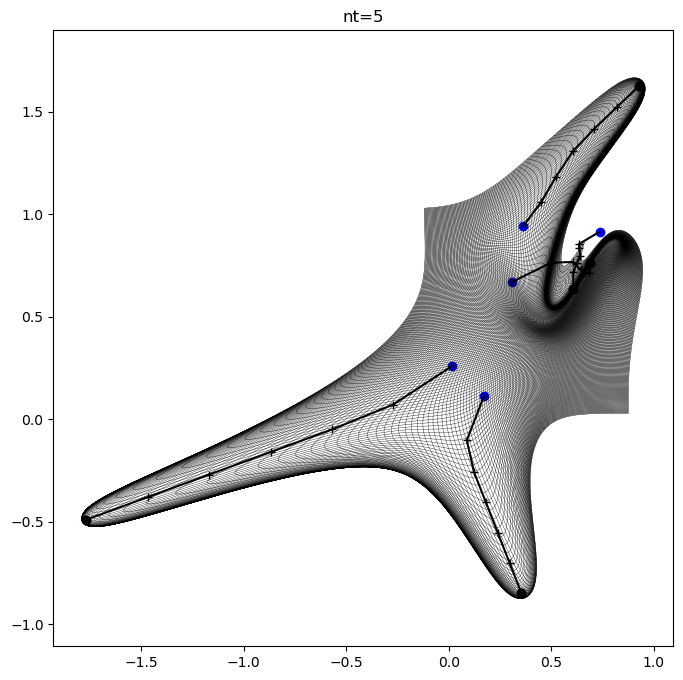

In [76]:
#Generation de points aléatoires de dimension 2
p0 = np.random.randn(5,2)
print(p0)
q0 = lmk1

q_1,p_1,Q = shooting(torch.tensor(p0, requires_grad = True),torch.tensor(q0, requires_grad = True),gauss_torch(sigma))
Q = Q.detach().numpy() #convert tensor to numpy
q_1 = q_1.detach().numpy()
phi = MatchingSteps(Q,gauss(sigma))
plt.figure(figsize = (8,8))
PlotResMatching(phi,q0,q_1,Q=Q,title = 'nt=5')

<br>

__Question 8__ : Enfin 
écrire une fonction `loss(p0,q0,z,h)` renvoyant la somme des carrés des distances des $q_i(1)$ aux $z_i$, et réaliser une descente de gradient simple sur cette fonction afin d'optimiser sur les moments initiaux (faire $1000$ itérations avec pas de descente $0.001$). Afficher les trajectoires $q_i(t)$ et l'appariement difféomorphique obtenu, et comparer avec les 
résultats de la question 3.

Les points bleus sont les points de départ, et les points noirs ceux d'arrivés.

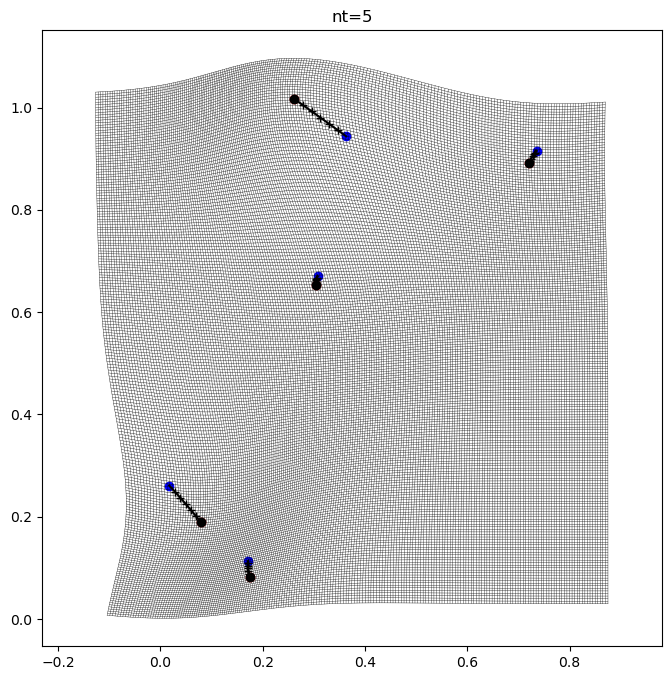

In [78]:
def shooting2(p0,q0,h):

    T = 1 # duration of the simulation
    N = 7 #number of steps
    time_step = T/N
    for _ in range(1,N):
        grad_p,grad_q = HamiltSys(p0, q0, h)
        p0= p0 + time_step*grad_p
        q0 = q0 + time_step*grad_q
    return q0

def loss(p0,q0,z,h):
    q1 = shooting2(p0,q0,h)
    return torch.sum((q1 - z)**2)

#Generation de points aléatoires de dimension 2
p0 = np.random.randn(5,2)
q0 = lmk1

p0 = torch.tensor(p0, requires_grad=True)
q0 = torch.tensor(q0, requires_grad=True)

eta = 0.01
for _ in range(1000):
    J = loss(p0,q0,torch.tensor(lmk2),h)
    G = grad(J,p0)[0]
    p0.data -= eta*G.data

q_1,p_1,Q = shooting(p0,q0,gauss_torch(sigma))
Q = Q.detach().numpy() #convert tensor to numpy
q_1 = q_1.detach().numpy()
q0 = q0.detach().numpy()
phi = MatchingSteps(Q,gauss(sigma))
plt.figure(figsize = (8,8))
PlotResMatching(phi, q0, q_1, Q=Q, title = 'nt=5')